# Importing Libraries and Downloading Data

In [1]:
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt
import numpy as np
import random
import scipy
from sklearn.metrics import accuracy_score, f1_score
from scipy.signal import cwt, ricker, morlet, welch
from scipy.stats import mode, skew, kurtosis, entropy
from scipy.fft import fft, fftfreq
from scipy.signal import stft
from sklearn.neighbors import KNeighborsClassifier

C:\Users\ytw\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ytw\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\ytw\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\ytw\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
import gdown
# Replace 'YOUR_FILE_ID' with the actual file ID from Google Drive
file_id1 = '1ey3lfsGJk8K8jCdOGROF8VK3IA8rr-e7'
file_id2 = '1xp8gvcMsc6h8OuRSnXrQIH1PlLR2wa-s'

# Replace 'output_file.extension' with the desired name and extension for the downloaded file
output_file1 = 'InsectSound_TRAIN.arff'
output_file2 = 'InsectSound_TEST.arff'

# Construct the download link
url1 = f'https://drive.google.com/uc?id={file_id1}'
url2 = f'https://drive.google.com/uc?id={file_id2}'

# Download the file using gdown
gdown.download(url1, output_file1, quiet=False)
gdown.download(url2, output_file2, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ey3lfsGJk8K8jCdOGROF8VK3IA8rr-e7
To: /content/InsectSound_TRAIN.arff
100%|██████████| 168M/168M [00:01<00:00, 91.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1xp8gvcMsc6h8OuRSnXrQIH1PlLR2wa-s
To: /content/InsectSound_TEST.arff
100%|██████████| 168M/168M [00:02<00:00, 63.6MB/s]


'InsectSound_TEST.arff'

# Pre-processing

In [3]:
data1 = arff.loadarff(r'insects/InsectSound_TRAIN.arff')
train= pd.DataFrame(data1[0])

data2 = arff.loadarff(r'insects/InsectSound_TEST.arff')
test= pd.DataFrame(data2[0])

# get rid of empty data points
train = train[~train.duplicated(subset=train.columns[:-1], keep=False)]
test = test[~test.duplicated(subset=test.columns[:-1], keep=False)]

# for random seed for consistency
random_seed = 1222

In [4]:
# split the training and testing set
def split(ratio, data):
    # Group by the label column
    grouped = data.groupby('target')

    df_train = pd.DataFrame()
    df_test = pd.DataFrame()

    # Split each group into training and testing sets
    for label, group in grouped:
        # Shuffle the group data
        group = group.sample(frac=1, random_state=random_seed).reset_index(drop=True)
        # Calculate the index for splitting
        split_index = int(ratio * len(group))
        # Split into training and testing sets
        group_train = group[:split_index]
        group_test = group[split_index:]

        df_train = pd.concat([df_train, group_train])
        df_test = pd.concat([df_test, group_test])

    # Shuffle the data order
    df_train = df_train.sample(frac=1, random_state=random_seed).reset_index(drop=True)
    df_test = df_test.sample(frac=1, random_state=random_seed).reset_index(drop=True)

    return df_train, df_test

In [5]:
# get a better class labels
def labelset(df):
    original_labels = set(list(df['target']))
    labeldict = {element: i for i, element in enumerate(original_labels, start=0)}
    new_labels = [labeldict[key] for key in list(df['target'])]
    return new_labels


In [6]:
# Data/label Split
def prep(df1, df2):
    # copy the original dataset just in case
    df1_copy = df1.copy()
    df2_copy = df2.copy()

    y_train = labelset(df1)
    y_test = labelset(df2)


    df1_copy.drop('target', inplace=True, axis=1)
    df2_copy.drop('target', inplace=True, axis=1)

    x_train = df1_copy
    x_test = df2_copy

    return x_train, y_train, x_test, y_test

In [7]:
#combined_normalized Training and Test Set
combined = pd.concat([train, test], axis=0)
# split it into training and testing
training, testing = split(0.6, combined)
# split it into data and labels
X_train, y_train, X_test, y_test = prep(training, testing)

# Describe Dataset

In [ ]:
#Check if every class is equally split
train_class_distribution = np.bincount(y_train)
test_class_distribution = np.bincount(y_test)

print("Class distribution in training set:", train_class_distribution)
print("Class distribution in testing set:", test_class_distribution)

Class distribution in training set: [3000 3000 2998 2999 2999 3000 2999 2998 2999 3000]
Class distribution in testing set: [2000 2000 2000 2000 2000 2000 2000 2000 2000 2000]


For showing patterns of each classes, take the mean of each class

In [ ]:
# convert the bytes to strings for label
combined['target'] = combined['target'].apply(lambda x: x.decode() if isinstance(x, bytes) else x)

# Split DataFrame based on the last column (Column3 in this case)
grouped = combined.groupby('target')
# Create a dictionary to store the split DataFrames
split_dfs = {}

# Iterate through the groups and create separate DataFrames
for value, group_df in grouped:
    split_dfs[value] = group_df

# Access the split DataFrames using the unique values in the last column
cl0 = split_dfs['Fruit_flies']
cl1 = split_dfs['Tarsalis_male']
cl2 = split_dfs['Quinx_female']
cl3 = split_dfs['House_flies']
cl4 = split_dfs['Stigma_male']
cl5 = split_dfs['Aedes_female']
cl6 = split_dfs['Stigma_female']
cl7 = split_dfs['Aedes_male']
cl8 = split_dfs['Tarsalis_female']
cl9 = split_dfs['Quinx_male']

In [ ]:
# calculate the mean of each row
def cal_mean_class(df):
    return df.iloc[:, :-1].mean().values

# the mean of each class
class_means = [cal_mean_class(cl0), cal_mean_class(cl1), cal_mean_class(cl2),
              cal_mean_class(cl3), cal_mean_class(cl4), cal_mean_class(cl5),
              cal_mean_class(cl6), cal_mean_class(cl7), cal_mean_class(cl8),
              cal_mean_class(cl9)]


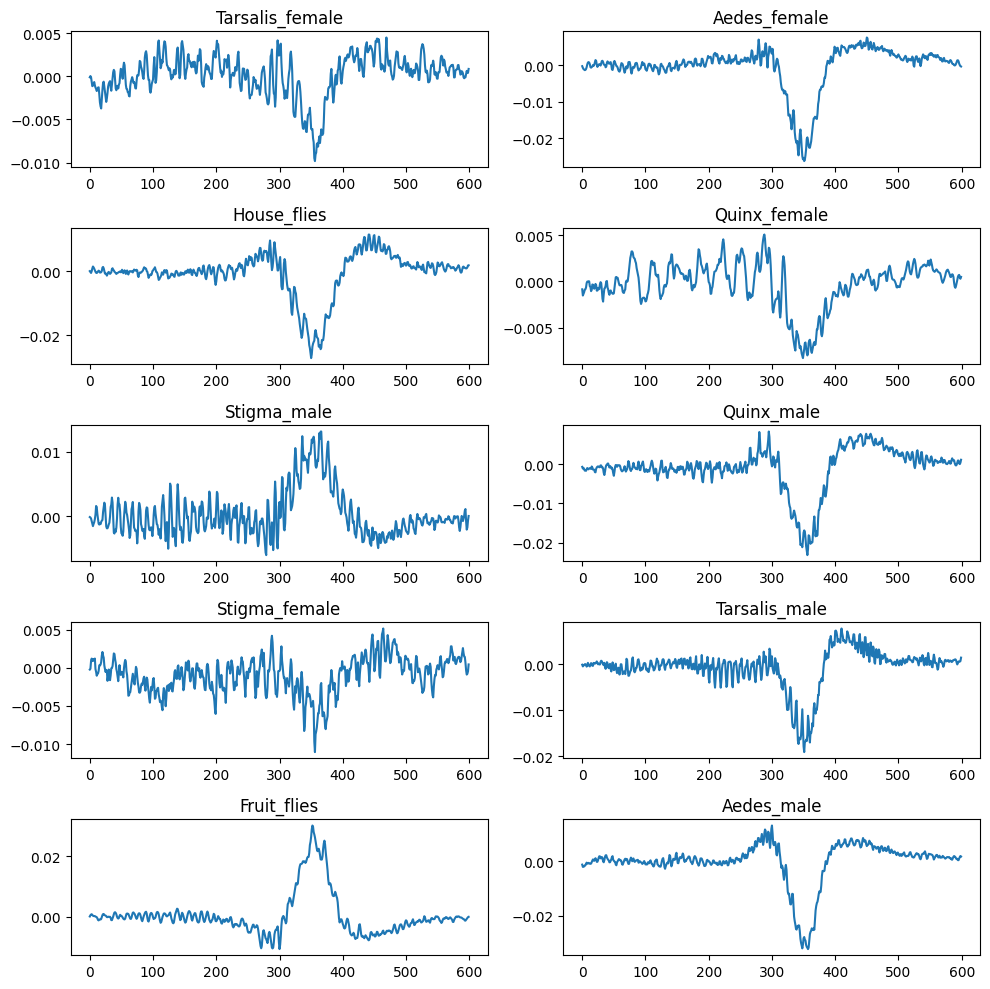

In [ ]:
# the label of each class
original_labels = set(list(combined['target']))
labeldict = {element: i for i, element in enumerate(original_labels, start=0)}

# show each class
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 10))

# Flatten the subplot array for easy iteration
axs = axs.flatten()

# Plot each list in a subplot
for i, ax in enumerate(axs):
    ax.plot(class_means[i])
    ax.set_title(list(labeldict.keys())[i])

# Adjust layout and display plot
plt.tight_layout()
plt.show()

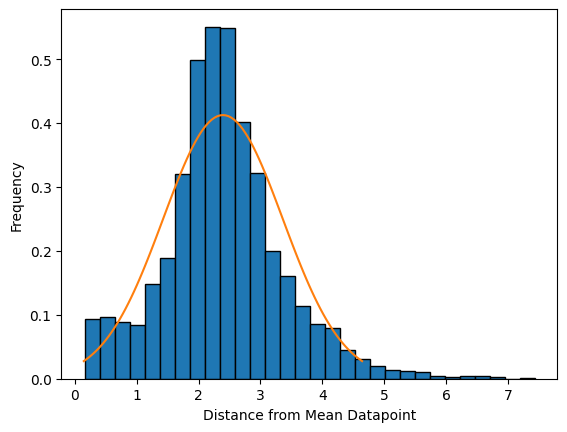

In [ ]:
# show the distance of each datapoint to mean class point, reflex chaoness of dataset
distances = np.linalg.norm(cl2.iloc[:, :-1].values - cal_mean_class(cl2), axis=1)

plt.hist(distances, bins=30, edgecolor='black', density=True)
# create a good lower and upper horizontal bound for the plot
xmin = scipy.stats.norm.ppf(0.01, loc=np.mean(distances), scale=np.std(distances))
xmax = scipy.stats.norm.ppf(0.99, loc=np.mean(distances), scale=np.std(distances))
xs  = np.linspace(xmin, xmax, 101)
plt.plot(xs, scipy.stats.norm.pdf(xs, loc=np.mean(distances), scale=np.std(distances)))
plt.xlabel('Distance from Mean Datapoint')
plt.ylabel('Frequency')
plt.show()


# Evalution Model

In [12]:
# knn model
def simple_knn(X_train, y_train, X_test, y_test):
  # Create a KNN classifier
  knn_classifier = KNeighborsClassifier(n_neighbors=10)

  # Train the classifier on the training data
  knn_classifier.fit(X_train, y_train)

  # Make predictions on the test data
  y_pred = knn_classifier.predict(X_test)

  # Evaluate the accuracy of the classifier
  f1 = f1_score(y_test, y_pred, average='weighted')

  return f1

In [13]:
def k_folds(X, y, k):
    # Calculate the number of samples and indices
    num_samples = len(y)
    indices = np.arange(num_samples)

    # Shuffle the indices
    np.random.seed(random_seed)
    np.random.shuffle(indices)

    # Split the indices into k folds
    folds = np.array_split(indices, k)

    # Initialize a list to store the accuracy scores for each fold
    f1_scores = []

    # Perform k-fold cross-validation
    for i in range(k):
        validation_indices = folds[i]
        train_indices = np.concatenate([fold for j, fold in enumerate(folds) if j != i])

        # Use the current fold as the validation set
        validation_X = X.values[validation_indices]
        validation_y = [y[idx] for idx in validation_indices]
        train_X = X.values[train_indices]
        train_y = [y[idx] for idx in train_indices]

    return validation_X, validation_y, train_X, train_y

In [14]:
# will take longer time
def knn_cv(X_train, y_train, X_test, y_test, k):
  validation_X, validation_y, train_X, train_y = k_folds(X_train, y_train, k)

  knn_classifier = KNeighborsClassifier(n_neighbors=10)
  f1_scores = []
  for i in range(k):
    # Fit the classifier on the training set
    knn_classifier.fit(train_X, train_y)

    # Evaluate the classifier on the validation set
    y_pred = knn_classifier.predict(validation_X)

    # Evaluate the accuracy of the classifier
    f1_scores.append(f1_score(validation_y, y_pred, average='weighted'))

  return np.mean(f1_scores)

cross validation evaluates on validation set, code below is to compare testing set and validation set, showing whether overfitting or not

In [8]:
# store result of all the features
result = {}

In [ ]:
# fitting on raw data
result['raw_data cv'] = knn_cv(X_train, y_train, X_test, y_test, 5)
result['raw_data'] = simple_knn(X_train, y_train, X_test, y_test)

#Baseline - Stats Features

In [16]:
# function the calculate the statics of data
def transform_stats(df):
    stats = {'mean': [], 'median': [], 'mode': [], 'std': [], 'skew': [], 'kurt': []}
    for i in range(len(df)):
        row_data = df.iloc[i].values
        stats['mean'].append(np.mean(row_data))
        stats['median'].append(np.median(row_data))
        stats['mode'].append((mode(row_data).mode)[0])
        stats['std'].append(np.std(row_data))
        stats['skew'].append(skew(row_data))
        stats['kurt'].append(kurtosis(row_data))
    stats_data = pd.DataFrame(stats)
    return stats_data

In [17]:
X_train_stat = transform_stats(X_train)
X_test_stat = transform_stats(X_test)
X_test_stat

,mean,median,mode,std,skew,kurt
0,-0.008322,-0.009875,-0.455823,0.175700,0.236911,0.680319
1,-0.000065,-0.000554,-0.496920,0.167889,0.038785,0.529679
2,-0.003233,0.000000,0.000000,0.087802,-0.277238,11.646856
3,-0.000711,0.000082,-0.225130,0.051210,1.435426,18.481410
4,-0.000047,0.000532,-0.314224,0.082151,0.824587,8.137976
...,...,...,...,...,...,...
19995,-0.011421,-0.022422,-0.432809,0.083765,1.827748,11.814547
19996,-0.000150,0.000092,-0.062792,0.020773,1.406138,9.304097
19997,0.004317,-0.009019,-0.488225,0.170425,0.120271,-0.603846
19998,0.016788,0.025034,-0.457300,0.155083,-0.365876,0.719459


In [15]:
result['baseline cv'] = knn_cv(X_train_stat, y_train, X_test_stat, y_test, 5)
result['baseline'] = simple_knn(X_train_stat, y_train, X_test_stat, y_test)
result

{'baseline cv': 0.16137876269730858, 'baseline': 0.15999017798880308}

# Fourier Transform

In [ ]:
# FFT Calculation
def calculate_fft(time_series):
    sampling_rate = 6000 # Our data is sampled at 6000Hz as specified by the dataset
    # add abs value to avoid imaginary numbers
    fft_result = np.fft.fft(time_series)
    # Get the power spectrum (magnitude of the FFT)
    power_spectrum = np.abs(fft_result)
    # Generate frequency axis data
    frequency = np.fft.fftfreq(len(power_spectrum), d=1./sampling_rate)
    # Only take the positive frequencies
    positive_frequency = frequency[:len(frequency)//2]
    positive_power_spectrum = power_spectrum[:len(power_spectrum)//2]

    return positive_frequency * positive_power_spectrum

In [ ]:
fft_X_train = X_train.apply(calculate_fft, axis=1, result_type='expand')
fft_X_test = X_test.apply(calculate_fft, axis=1, result_type='expand')
fft_X_test.values.shape

(20000, 300)

In [ ]:
# for ploting
def plot_time_series_and_spectrum(time_series_data):

    # Increase font size for titles and labels
    title_fontsize = 17
    label_fontsize = 15

    # Calculate the FFT and frequencies
    sampling_rate = 6000
    fft_result = np.fft.fft(time_series_data)
    power_spectrum = np.abs(fft_result)
    frequencies = np.fft.fftfreq(len(power_spectrum), d=1./sampling_rate)

    # Prepare for single-sided spectrum
    positive_frequencies = frequencies[:len(frequencies)//2]
    positive_power_spectrum = power_spectrum[:len(power_spectrum)//2]

    # Create a subplot for the original time series
    fig, axs = plt.subplots(2, 1, figsize=(12, 8))

    # Plot the original time series
    tick_spacing = 100
    axs[0].plot(time_series_data)
    axs[0].set_title('Original Time Series', fontsize=title_fontsize)
    axs[0].set_xlabel('Time [10ms]', fontsize = label_fontsize)
    axs[0].set_ylabel('Amplitude', fontsize = label_fontsize)

    # Plot the single-sided amplitude spectrum
    axs[1].plot(positive_frequencies, positive_power_spectrum)
    axs[1].set_title('Fourier Transformed Data (Single-Sided Amplitude Spectrum)', fontsize=title_fontsize)
    axs[1].set_xlabel('Frequency [Hz]', fontsize = label_fontsize)
    axs[1].set_ylabel('Amplitude', fontsize = label_fontsize)

    # Display the plots
    plt.tight_layout()
    plt.show()


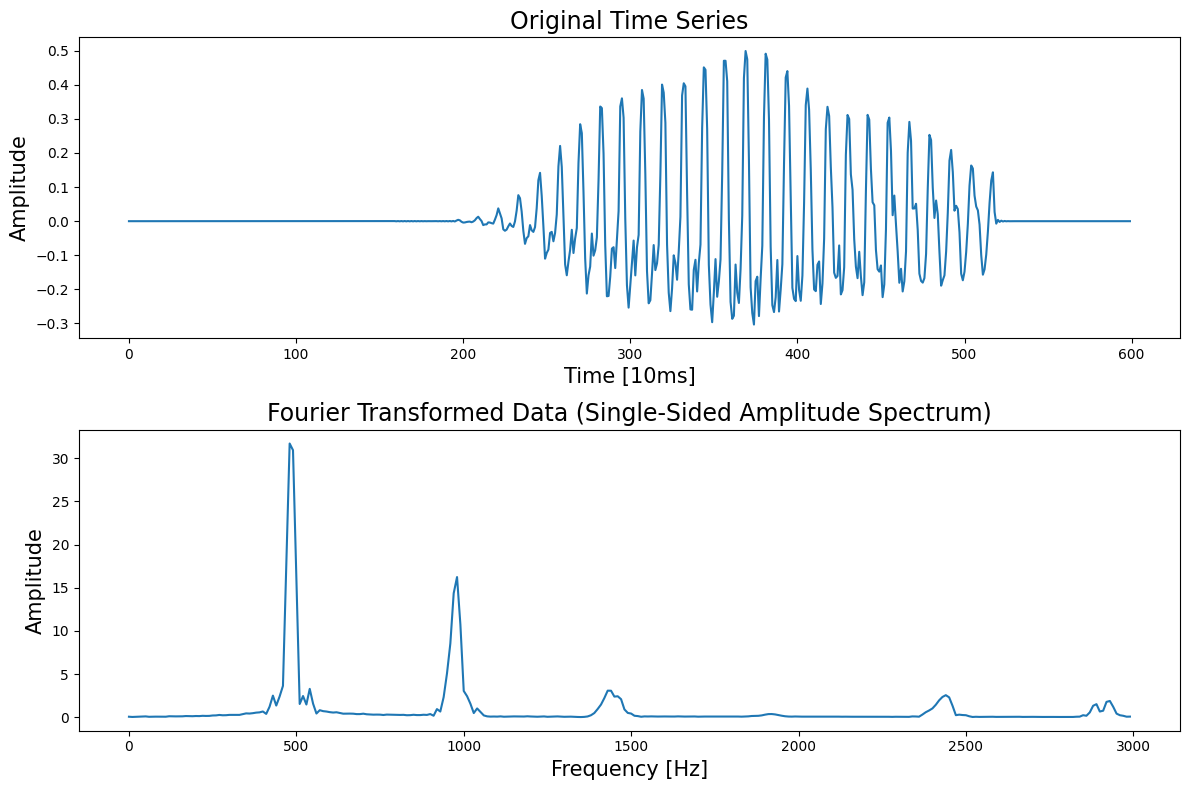

In [ ]:
plot_time_series_and_spectrum(X_train.iloc[7].values)

In [ ]:
result['fft cv'] = knn_cv(fft_X_train, y_train, fft_X_test, y_test, 5)
result['fft'] = simple_knn(fft_X_train, y_train, fft_X_test, y_test)
result

{'raw_data cv': 0.5273385846461748,
 'raw_data': 0.40704736349168497,
 'baseline cv': 0.16460325964511244,
 'baseline': 0.1408578479927171,
 'fft cv': 0.6857099541425773,
 'fft': 0.5593481135319142}

# Temporal Integration


In [ ]:
# Short-time Fourier Transform Function - Temporal Integration (Highest Stats Features) (71.3% - cross-validation)
def stft_features(signal):

    X_flattened_list = []
    signal = np.array(signal)

    # Perform STFT
    f, t_spec, Zxx = stft(signal, fs=6000, nperseg=128)

    # Summing the spectrogram along the time axis to see how frequency content changes
    temporal_int = np.sum(np.abs(Zxx), axis=1)
    flattened_spec = temporal_int.reshape(-1)
    X_flattened_list.extend(list(flattened_spec))

    return X_flattened_list

In [ ]:
# Apply STFT Features to X_train and X_test
stft_X_train = X_train.apply(stft_features, axis=1, result_type = 'expand')
stft_X_test = X_test.apply(stft_features, axis=1, result_type = 'expand')

In [ ]:
result['stft cv'] = knn_cv(stft_X_train, y_train, stft_X_test, y_test, 5)
result['stft'] = simple_knn(stft_X_train, y_train, stft_X_test, y_test)
result

{'raw_data cv': 0.5273385846461748,
 'raw_data': 0.40704736349168497,
 'baseline cv': 0.16460325964511244,
 'baseline': 0.1408578479927171,
 'fft cv': 0.6857099541425773,
 'fft': 0.5593481135319142,
 'stft cv': 0.6867377834200235,
 'stft': 0.5564833919497537}

#Spectral Rolloff

In [ ]:
#Spectral Rolloff (F1 - 0.45)


def stft_spectral_rolloff_features(signal):

    X_flattened_list = []
    signal = np.array(signal)

    # Perform STFT
    f, t_spec, Zxx = stft(signal, fs=6000, nperseg = 128)  # You can adjust nperseg according to your requirements
    Sxx = np.abs(Zxx)

    spectral_rolloff = np.zeros(Zxx.shape[1])  # Initialize array for each time segment
    for j in range(Zxx.shape[1]):
        total_energy = np.sum(np.abs(Zxx[:, j]) ** 2)
        cumulative_energy = 0.85 * total_energy
        cumulative_sum = 0
        for k in range(len(f)):
            cumulative_sum += np.abs(Zxx[k, j]) ** 2
            if cumulative_sum >= cumulative_energy:
                spectral_rolloff[j] = f[k]
                break

    X_flattened_list.extend(list(spectral_rolloff))

    return X_flattened_list

In [ ]:
# Apply Spectral Rolloff Features to X_train and X_test
roll_X_train = X_train.apply(stft_spectral_rolloff_features, axis=1, result_type = 'expand')
roll_X_test = X_test.apply(stft_spectral_rolloff_features, axis=1, result_type = 'expand')

In [ ]:
result['rolloff cv'] = knn_cv(roll_X_train, y_train, roll_X_test, y_test, 5)
result['rolloff'] = simple_knn(roll_X_train, y_train, roll_X_test, y_test)
result

{'raw_data cv': 0.5273385846461748,
 'raw_data': 0.40704736349168497,
 'baseline cv': 0.16460325964511244,
 'baseline': 0.1408578479927171,
 'fft cv': 0.6857099541425773,
 'fft': 0.5593481135319142,
 'stft cv': 0.6867377834200235,
 'stft': 0.5564833919497537,
 'rolloff cv': 0.3188308005885215,
 'rolloff': 0.2721636262546182}

# Spectral Density Extraction

In [ ]:
# Create a function to extract spectral density and frequencies

def spec_features(input):

  fs = 6000 # Because our data is sampled every 10ms

  frequencies, power_density = welch(input, fs, nperseg = 80)
  features = frequencies * power_density

  return features

In [ ]:
spec_X_train = X_train.apply(spec_features, axis=1, result_type='expand')
spec_X_test = X_test.apply(spec_features, axis=1, result_type='expand')
spec_X_test.shape

(20000, 41)

In [ ]:
result['spec cv'] = knn_cv(spec_X_train, y_train, spec_X_test, y_test, 5)
result['spec'] = simple_knn(spec_X_train, y_train, spec_X_test, y_test)
result

{'raw_data cv': 0.5273385846461748,
 'raw_data': 0.40704736349168497,
 'baseline cv': 0.16460325964511244,
 'baseline': 0.1408578479927171,
 'fft cv': 0.6857099541425773,
 'fft': 0.5593481135319142,
 'stft cv': 0.6867377834200235,
 'stft': 0.5564833919497537,
 'rolloff cv': 0.3188308005885215,
 'rolloff': 0.2721636262546182,
 'spec cv': 0.637844312790924,
 'spec': 0.5187405321999917}

For plotting

In [ ]:
def spec(input_signal):

    fs = 6000  # Because our data is sampled every 10ms

    frequencies, power_density = welch(input_signal, fs, nperseg=80)

    return frequencies, power_density



# Function to plot the original time series and its power spectral density

def plot_time_series_and_power_density(time_series_data):

    title_fontsize = 17
    label_fontsize = 15
    # Extract spectral density and frequencies

    frequencies, power_density = spec(time_series_data)



    # Create a subplot for the original time series and power spectral density

    fig, axs = plt.subplots(2, 1, figsize=(12, 8))



    # Plot the original time series

    tick_spacing = 100
    axs[0].plot(time_series_data)
    axs[0].set_title('Original Time Series', fontsize=title_fontsize)
    axs[0].set_xlabel('Time [10ms]', fontsize = label_fontsize)
    axs[0].set_ylabel('Amplitude', fontsize = label_fontsize)


    # Plot the power spectral density

    axs[1].semilogy(frequencies, power_density)  # Log scale for the y-axis

    axs[1].set_title('Power Spectral Density', fontsize=title_fontsize)

    axs[1].set_xlabel('Frequency [Hz]', fontsize = label_fontsize)

    axs[1].set_ylabel('Power Density [W/Hz]', fontsize = label_fontsize)



    # Display the plots

    plt.tight_layout()

    plt.show()


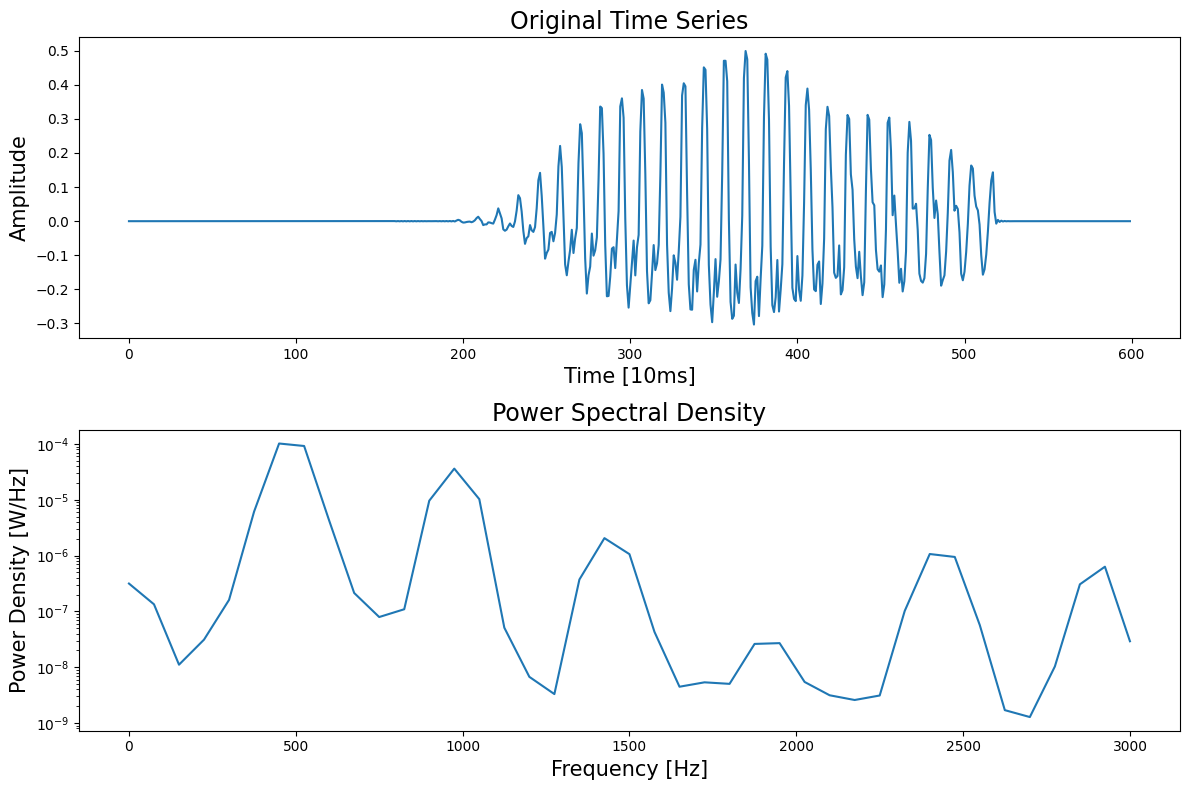

In [ ]:
plot_time_series_and_power_density(X_train.iloc[7].values)

# Wavelets


In [ ]:
def wt_transform(input):

  widths = np.arange(1, 15)
  cwtmatr = cwt(input, ricker, widths)

  # Initialize a list to store features for each scale
  all_features = []

  # Extract features for each scale
  for i in range(len(widths)):
      scale_features = []
      scale_coeffs = cwtmatr[i, :]

      # Statistical Features
      scale_features.append(np.mean(scale_coeffs))
      scale_features.append(np.std(scale_coeffs))
      scale_features.append(np.max(scale_coeffs))
      scale_features.append(np.min(scale_coeffs))
      scale_features.append(np.max(scale_coeffs) - np.min(scale_coeffs))

      # Add the feature array for this scale to the list
      all_features.extend(scale_features)

  return all_features


In [ ]:
%%time
wt_X_train = X_train.apply(wt_transform, axis=1, result_type='expand')
wt_X_test = X_test.apply(wt_transform, axis=1, result_type='expand')
wt_X_test.values.shape

CPU times: user 2min 11s, sys: 472 ms, total: 2min 12s
Wall time: 2min 13s


(20000, 70)

In [ ]:
result['wave cv'] = knn_cv(wt_X_train, y_train, wt_X_test, y_test, 5)
result['wave'] = simple_knn(wt_X_train, y_train, wt_X_test, y_test)
result

{'raw_data cv': 0.5273385846461748,
 'raw_data': 0.40704736349168497,
 'baseline cv': 0.16460325964511244,
 'baseline': 0.1408578479927171,
 'fft cv': 0.6857099541425773,
 'fft': 0.5593481135319142,
 'stft cv': 0.6867377834200235,
 'stft': 0.5564833919497537,
 'rolloff cv': 0.3188308005885215,
 'rolloff': 0.2721636262546182,
 'spec cv': 0.637844312790924,
 'spec': 0.5187405321999917,
 'wave cv': 0.5930847879382627,
 'wave': 0.47259176819562354}

# feature result

In [ ]:
result_df = pd.DataFrame(list(result.items()), columns=['feature', 'F1'])
# change the format of result
result_table = {'feature': ['raw data', 'baseline', 'fft', 'stft', 'rolloff', 'spec', 'wavelet'],
        'cv score': list(result_df[result_df.index % 2 != 1]['F1']),
        'test score': list(result_df[result_df.index % 2 != 0]['F1'])}
table_df = pd.DataFrame(result_table)
table_df

,feature,cv score,test score
0,raw data,0.527339,0.407047
1,baseline,0.164603,0.140858
2,fft,0.685710,0.559348
3,stft,0.686738,0.556483
4,rolloff,0.318831,0.272164
5,spec,0.637844,0.518741
6,wavelet,0.593085,0.472592


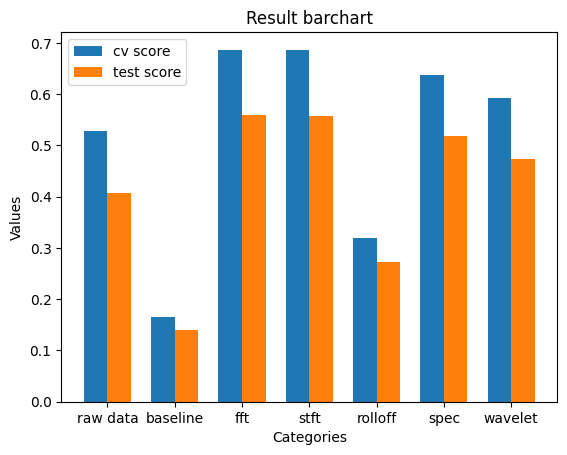

In [ ]:
# display
bar_width = 0.35
bar_positions = range(len(table_df['feature']))

plt.bar(bar_positions, table_df['cv score'], width=bar_width, label='cv score')
plt.bar([pos + bar_width for pos in bar_positions], table_df['test score'], width=bar_width, label='test score')

# Adding labels and title
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Result barchart')

# Adding legend
plt.legend()

# Adjusting x-axis ticks and labels
plt.xticks([pos + bar_width/2 for pos in bar_positions], table_df['feature'])

# Display the chart
plt.show()


# Tuning Hyperparameter

In [ ]:
def cross_validation(X_train, y_train, k, classifier):
    """
    Parameters:
    - X_train: Feature matrix for the training set
    - y_train: Target variable for the training set
    - k: Number of folds
    - classifier: The classifier model

    Returns:
    - List of accuracy scores for each fold
    """

    # Calculate the number of samples and indices
    num_samples = len(y_train)
    indices = np.arange(num_samples)

    # Shuffle the indices
    np.random.seed(random_seed)
    np.random.shuffle(indices)

    # Split the indices into k folds
    folds = np.array_split(indices, k)

    # Initialize a list to store the accuracy scores for each fold
    f1_scores = []

    # Perform k-fold cross-validation
    for i in range(k):
        validation_indices = folds[i]
        train_indices = np.concatenate([fold for j, fold in enumerate(folds) if j != i])

        # Use the current fold as the validation set
        validation_X = X_train.values[validation_indices]
        validation_y = [y_train[idx] for idx in validation_indices]
        train_X = X_train.values[train_indices]
        train_y = [y_train[idx] for idx in train_indices]

        # Fit the classifier on the training set
        classifier.fit(train_X, train_y)

        # Evaluate the classifier on the validation set
        y_pred = classifier.predict(validation_X)

        # Evaluate the accuracy of the classifier
        f1_scores.append(f1_score(validation_y, y_pred, average='weighted'))

    return f1_scores

In [ ]:
def grid_search_cv(X_train, y_train, ns, weights, num_folds):
    mean_cv_f1 = {}
    for weight in weights:
      f1_weights = []
      for n in ns:
        knn = KNeighborsClassifier(n_neighbors=n, weights=weight)
        cross_val_scores = cross_validation(X_train, y_train, num_folds, knn)
        f1_weights.append(np.mean(cross_val_scores))
#       mean_cv_f1.append(f1_weights)
      mean_cv_f1[weight] = f1_weights
    return mean_cv_f1

In [ ]:
%%time
ns = [10, 20, 25, 30, 35, 40, 50]
weights = ['uniform', 'distance']
grid_search_stft = grid_search_cv(stft_X_train, y_train, ns, weights, 5)

CPU times: user 2min 52s, sys: 470 ms, total: 2min 52s
Wall time: 1min 50s


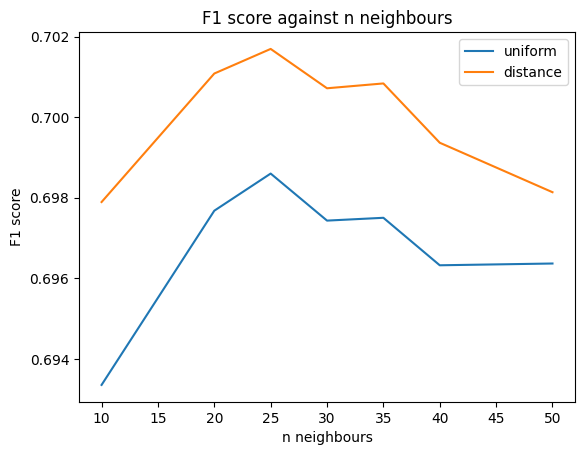

the best result of stft when use distance for n is 25, which is 0.701694155663341


In [ ]:
plt.plot(ns, list(grid_search_stft.values())[0], label=weights[0])
plt.plot(ns, list(grid_search_stft.values())[1], label=weights[1])
plt.title('F1 score against n neighbours')
plt.xlabel('n neighbours')
plt.ylabel('F1 score')
plt.legend()
plt.show()

# locate the best parameter
best_weight = max(grid_search_stft, key=lambda k: max(enumerate(grid_search_stft[k]), key=lambda x: x[1])[1])
best_n = ns[max(enumerate(grid_search_stft[best_weight]), key=lambda x: x[1])[0]]
max_result = max((max(lst) for lst in grid_search_stft.values()))

print(f'the best result of stft when use {best_weight} for n is {best_n}, which is {max_result}')

In [ ]:
# the best model
knn_classifier = KNeighborsClassifier(n_neighbors=best_n, weights=best_weight)

# Train the classifier on the training data
knn_classifier.fit(stft_X_train, y_train)

# Make predictions on the test data
y_pred = knn_classifier.predict(stft_X_test)

# Evaluate the accuracy of the classifier
f1 = f1_score(y_test, y_pred, average='weighted')

f1

0.5634106424512946

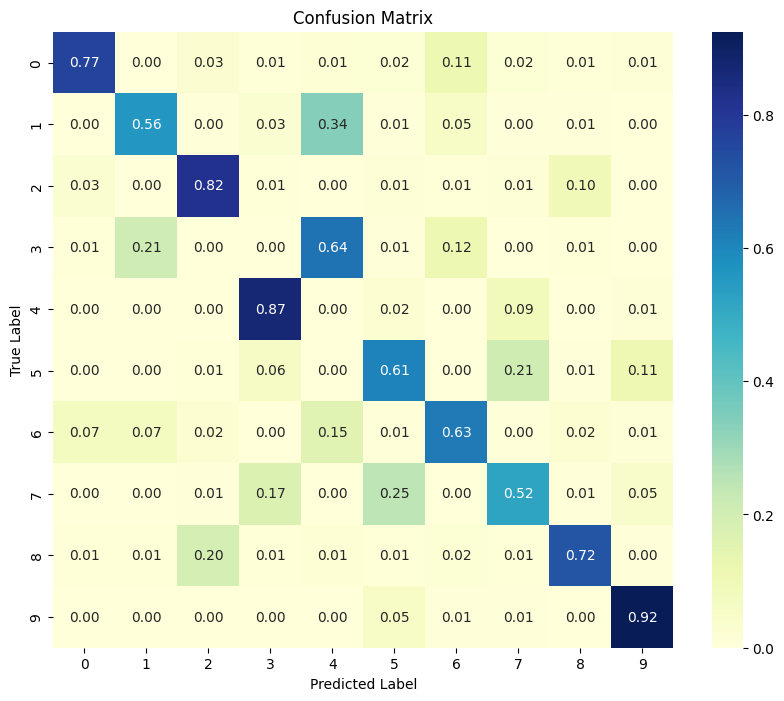

In [ ]:
# seems not allowed to use, just here to see
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# Calculate confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix
conf_mat_norm = conf_mat / conf_mat.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_norm, annot=True, fmt=".2f", cmap="YlGnBu",
            xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# discussion

investigate realtionship between overfitting and split ratio

In [ ]:
# on raw data
split_ratio = [round(i * 0.1, 1) for i in range(1, 10)]

def pre(train, test, ratio):
    #combined_normalized Training and Test Set
    combined_normalized = pd.concat([train, test], axis=0)
    # split it into training and testing
    training, testing = split(ratio, combined_normalized)
    # split it into data and labels
    X_train, y_train, X_test, y_test = prep(training, testing)

    return X_train, y_train, X_test, y_test

In [ ]:
%time
result = {}
for ratio in split_ratio:
    X_train, y_train, X_test, y_test = pre(train, test, ratio)
    result[f'{ratio} cv'] = knn_cv(X_train, y_train, X_test, y_test, 5)
    result[f'{ratio}'] = simple_knn(X_train, y_train, X_test, y_test)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.06 µs


In [ ]:
result_df = pd.DataFrame(list(result.items()), columns=['ratio', 'F1'])
# change the format of result
result_table = {'ratio': split_ratio,
        'cv score': list(result_df[result_df.index % 2 != 1]['F1']),
        'test score': list(result_df[result_df.index % 2 != 0]['F1'])}
table_df = pd.DataFrame(result_table)
table_df

,ratio,cv score,test score
0,0.1,0.442807,0.446733
1,0.2,0.471291,0.476488
2,0.3,0.480657,0.379265
3,0.4,0.501636,0.388549
4,0.5,0.509344,0.522277
5,0.6,0.527339,0.407047
6,0.7,0.514837,0.533598
7,0.8,0.532127,0.531562
8,0.9,0.548334,0.409726


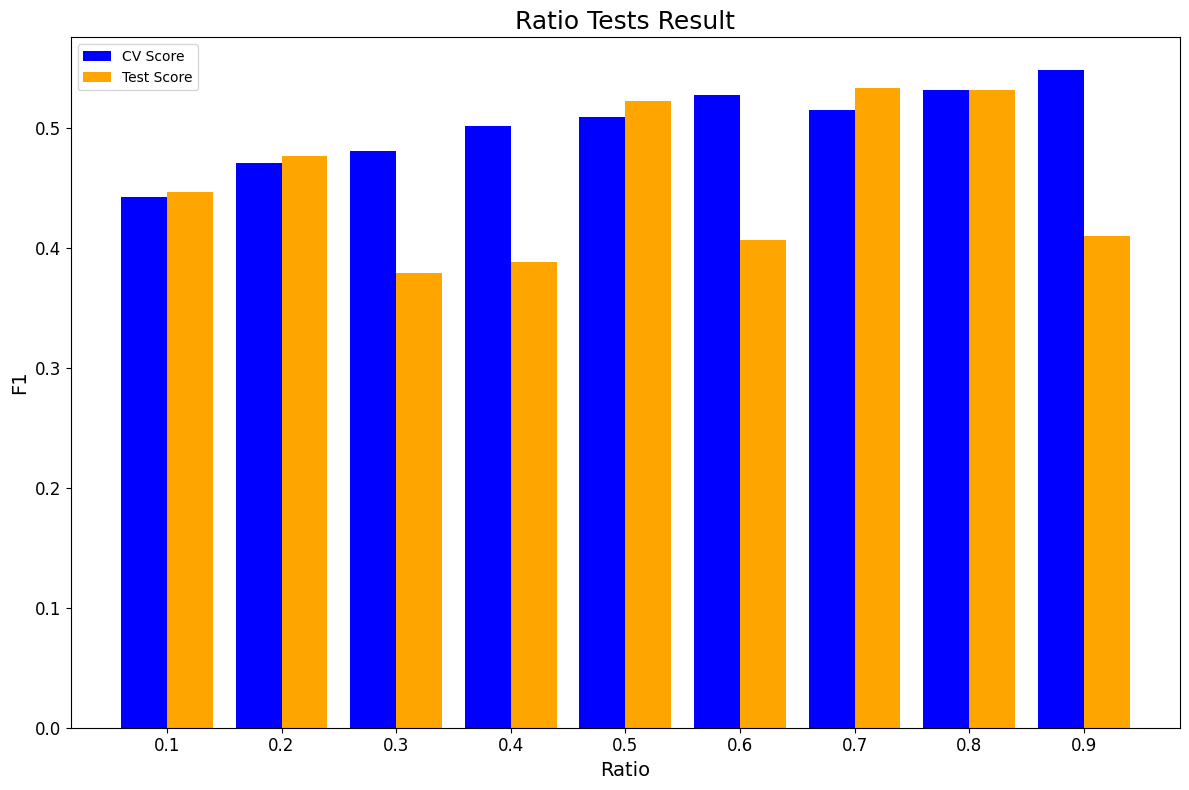

In [ ]:
plt.figure(figsize=(12, 8))

# Plotting both 'cv_score' and 'test_score' with respect to 'ratio'
plt.bar(table_df['ratio'] - 0.02, table_df['cv score'], width=0.04, color='blue', label='CV Score')
plt.bar(table_df['ratio'] + 0.02, table_df['test score'], width=0.04, color='orange', label='Test Score')

# Adding titles and labels
plt.title('Ratio Tests Result', fontsize=18)
plt.xlabel('Ratio', fontsize=14)
plt.ylabel('F1', fontsize=14)

plt.xticks(table_df['ratio'])

# Moving the legend to the upper left corner to avoid covering the bars
plt.legend(loc='upper left')

# Increase the font size for ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot with the adjustments
plt.tight_layout()  # Adjust the padding between and around subplots.
plt.show()
